# Algorithmic Data Science

---

# Introduction

This report will investigate the time complexity of various implementations of Jaccard and Cosine similarity measures. We will calculate each algorithm's theoretical performances, in addition to conducting experiments to compare the performances empirically. Additionally, we will also investigate the map-reduce paradigm for document similarity measure.

This report is broken down as follows:  
Section 1: Time Complexity of Jaccard Similarity Measure  
Section 2 & 3: Time Complexity of Cosine Similarity Measure  
Section 4: All-pair Document Similarity  
Section 5: Map-Reduce Paradigm  
Section 6: Conclusion

---


In [1]:
import numpy as np
import time
import random
import matplotlib.pyplot as plt

from nltk.corpus import brown
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import re

# Use as required
# import nltk
# nltk.download('brown')
# nltk.download('wordnet')
# nltk.download('stopwords')

In [2]:
"""
document = GetDocument (DSize)
dict = function (int)

This function generates a dictionary of words of length DSize.
The value for each word may be more than 1.
"""
def GetDocument (DSize):
    document = {}
    while (len(document) < DSize):
        wordList = random.sample(rawText, DSize)
        for word in wordList:
            if len(document) < DSize:
                document[word] = document.get(word,0) + 1
            else:
                break
    return document


"""
matrix = DictToVect (collection, CSize)
np.array = function (list(dict), int)

This function converts sparse representation into dense representation.
"""
def DictToVect (collection, CSize):
    # Counts all the unique tokens
    tokenCount = {}
    for document in collection:
        for key in document.keys():
            tokenCount[key] = tokenCount.get(key,0) + 1

    uniqueTokenCount = len(tokenCount)
    uniqueTokenList = list(tokenCount.keys())

    # Matrix of [CSize][uniqueTokenCount]
    matrix = np.zeros((CSize, uniqueTokenCount))

    for x, document in enumerate(collection):
        for key,val in document.items():
            y = uniqueTokenList.index(key)
            matrix[x][y] = val

    return matrix

"""
collection = GetCollection (CSize, DSize, RType)
list(dict) = function (int, int, 'dict')
np.array = function (int, int, 'vect')

This function generates a collection of documents, either in sparse or dense format.
The representation format is determined by the input argument 'RType'

Case insensitive.
RType == 'dict' : Returns sparse representation
RType == 'vect' : Returns dense representation

CSize sets the number of documents in the collection
DSize sets the number of unique features in a document
"""
def GetCollection (CSize, DSize, RType):
    # Make collection of random documents.
    # Collections of length CSize
    # Documents of length DSize
    collection = [GetDocument(DSize) for i in range(CSize)]

    # Returns sparse representation
    if (RType.lower() == 'dict'):
        return collection
    # Returns dense representation
    elif (RType.lower() == 'vect'):
        matrix = DictToVect(collection, CSize)
        return matrix
    else:
        raise NameError("Invalid return type RType=\'{0}\'".format(RType))

In [8]:
"""
Timing document-document comparison for each similarity measure
"""
def TimeDocument (fx, A, B, n=10):
    t = np.zeros(n)
    for i in range(n):
        st = time.time()
        fx (A, B)
        et = time.time()
        t[i] = et-st
    t *= 1000
    mean = np.mean(t)
    total = np.sum(t)
    stdev = np.std(t)
    error = stdev/(n**0.5)
    return [mean, total, stdev, error]


"""
Timing collection-collection for all-pair similarity
"""
def TimeCollection (fxallpair, fxsim, A, B, n=10):
    t = np.zeros(n)
    for i in range(n):
        st = time.time()
        fxallpair(fxsim, A, B)
        et = time.time()
        t[i] = et - st
    t *= 1000
    mean = np.mean(t)
    total = np.sum(t)
    stdev = np.std(t)
    error = stdev/(n**0.5)
    return [mean, total, stdev, error]


"""
Linear Scatter Plot Function
"""
def PlotLinear (x, y, **kwargs):
    fig, ax = plt.subplots(figsize=kwargs.get('figsize',(16,8)))

    if kwargs.get('eflag', True):
        # Calculates and plots error margin as area
        upper_error = y[:,0] + y[:,2]
        lower_error = y[:,0] - y[:,2]
        lim_idx = (lower_error <= 0)
        lower_error[lim_idx] = 0

        plt.plot (x, upper_error, color='blue', dashes=[8,4], alpha=0.25, label='upper error margin')
        plt.plot (x, lower_error, color='blue', dashes=[8,4], alpha=0.25, label='lower error margin')
        plt.fill_between (x, upper_error, lower_error, facecolor='blue', alpha=0.15, label='error margin')
    
    # y_data[i] = [mean, total, error, stdev]
    plt.scatter (x, y[:,0], color='orange', label=kwargs.get('funcname', 'Similarity Measure'))

    ax.set_xlabel(kwargs.get('xlabel', 'Document Size'))
    ax.set_ylabel(kwargs.get('ylabel', 'Average Runtime (ms)'))
    ax.set_title(kwargs.get('funcname', 'Similarity Measure') + ' Scatter Plot')

    # Best Fit Curve
    c = np.polyfit(x, y[:,0], 3)
    p = np.poly1d (c)
    l = np.linspace (x[0], x[-1], num=100)
    plt.plot (l, p(l), '--', color='black', alpha=0.75, label='Best Fit Curve')

    ax.legend(loc='upper left')
    plt.grid()
    plt.show()
    
    equation = f'{c[0]:.2e}*x^3 {c[1]:+.2e}*x^2 {c[2]:+.2e}*x {c[3]:+.2e}'
    print (f'Approximate Equation for line of best fit is: {equation}')
    print (f'Precise coefficient values: {c[0]} | {c[1]} | {c[2]} | {c[3]}')
    
    return (fig, ax, c)


"""
Logarithmic Scatter Plot Function
"""
def PlotLog (x, y, **kwargs):
    fig, ax = plt.subplots(figsize=kwargs.get('figsize',(16,8)))

    # Zero checks & converts to log
    # Removes any data point where y[mean] is zero as it breaks this function
    if (np.min(y[:,0]) == 0): 
        zflag = True
        zidx = (y[:,0] != 0)
        xlog = np.log10(x[zidx])
        ylog = np.log10(y[zidx,0])
    else:
        zflag = False
        xlog = np.log10(x)
        ylog = np.log10(y[:,0])
    
    plt.scatter (xlog, ylog, color='orange', label=kwargs.get('funcname', 'Similarity Measure'))

    ax.set_xlabel(kwargs.get('xlabel', 'Log10 of Document Size'))
    ax.set_ylabel(kwargs.get('ylabel', 'Log10 of Average Runtime (ms)'))
    ax.set_title(kwargs.get('funcname', 'Similarity Measure') + ' Logarithmic Plot')

    # Best Fit Curve
    c = np.polyfit(xlog, ylog, 1)
    p = np.poly1d (c)
    l = np.linspace (xlog[0], xlog[-1], num=100)
    plt.plot (l, p(l), '--', color='black', alpha=0.75, label='Best Fit Line')

    ax.legend(loc='upper left')
    plt.grid()
    plt.show()
    
    equation = '{0[0]:.2f}*x {0[1]:+.2f}'.format(c)
    print (f'Approximate Equation for line of best fit is: {equation}')
    print ('Precise coefficient values: {0[0]} | {0[1]}'.format(c))
    if zflag:
        print ('Warning: Data contains zero-values, data partially truncated to removed zero-valued points')
    
    return (fig, ax, c)


"""
Linear scatter plot function for comparing multiple datasets

x = single column vector of x data points
y = matrix of y data points, each column belonging to one dataset
datalabel = list of strings, containing the label for each dataset, in same order
colorlist = list of strings, containing the named color for each dataset, in same order
"""
def PlotLinearCompare (x, y, datalabel, colorlist, **kwargs):
    fig, ax = plt.subplots(figsize=kwargs.get('figsize',(16,8)))

    # data set count
    dsc = y.shape[1]
    
    # y_data[i,:] = [ds1[i], ds2[i], ds3[i], ...]
    for i in range (dsc):
        plt.scatter (x, y[:,i], label=datalabel[i], alpha=0.5, color=colorlist[i])
        
        if kwargs.get('typeflag','None') == 'linear':
            # Best Fit Line
            c = np.polyfit(x, y[:,i], 1)
            p = np.poly1d (c)
            l = np.linspace (x[0], x[-1], num=100)
            plt.plot (l, p(l), '--', alpha=0.75, label=datalabel[i], color=colorlist[i])
            equation = f'{c[0]:+.2e}*x {c[1]:+.2e}'
            print (f'Approximate Equation for line of best fit is: {equation}')
            print (f'Precise coefficient values: {c[0]} | {c[1]}')
        else:
            # Best Fit Curve
            c = np.polyfit(x, y[:,i], 3)
            p = np.poly1d (c)
            l = np.linspace (x[0], x[-1], num=100)
            plt.plot (l, p(l), '--', alpha=0.75, label=datalabel[i], color=colorlist[i])
            equation = f'{c[0]:+.2e}*x^3 {c[1]:+.2e}*x^2 {c[2]:+.2e}*x {c[3]:+.2e}'
            print (f'Approximate Equation for line of best fit is: {equation}')
            print (f'Precise coefficient values: {c[0]} | {c[1]} | {c[2]} | {c[3]}')
    
    ax.set_xlabel(kwargs.get('xlabel', 'Document Size'))
    ax.set_ylabel(kwargs.get('ylabel', 'Average Runtime (ms)'))
    ax.set_title (kwargs.get('title', 'Performance Comparison Scatter Plot'))

    ax.legend(loc='upper left')
    plt.grid()
    plt.show()
    
    return (fig, ax, c)


"""
Logarithmic scatter plot function for comparing multiple datasets

x = single column vector of x data points
y = matrix of y data points, each column belonging to one dataset
datalabel = list of strings, containing the label for each dataset, in same order
colorlist = list of strings, containing the named color for each dataset, in same order
"""
def PlotLogCompare (x, y, datalabel, colorlist, **kwargs):
    fig, ax = plt.subplots(figsize=kwargs.get('figsize',(16,8)))

    # Zero checks & converts to log
    # Removes any data point where y[mean] is zero as it breaks this function
    if (np.min(y) == 0): 
        zflag = True
        y[y == 0] = 0.1
        xlog = np.log10(x)
        ylog = np.log10(y)
    else:
        zflag = False
        xlog = np.log10(x)
        ylog = np.log10(y)
    
    # data set count
    dsc = y.shape[1]
    
    # List of equations to output later
    equations = []
    
    # y_data[i,:] = [ds1[i], ds2[i], ds3[i], ...]
    for i in range (dsc):
        plt.scatter (xlog, ylog[:,i], label=datalabel[i], alpha=0.5, color=colorlist[i])
        
        # Best Fit Curve
        c = np.polyfit(xlog, ylog[:,i], 1)
        p = np.poly1d (c)
        l = np.linspace (xlog[0], xlog[-1], num=100)
        plt.plot (l, p(l), '--', alpha=0.75, label=datalabel[i], color=colorlist[i])
        equations.append ('{0[0]:.3f}*x {0[1]:+.3f}'.format(c))
    
    ax.set_xlabel(kwargs.get('xlabel', 'Log10 of Document Size'))
    ax.set_ylabel(kwargs.get('ylabel', 'Log10 of Average Runtime (ms)'))
    ax.set_title(kwargs.get('title', 'Comparison Logarithmic Plot'))

    ax.legend(loc='upper left')
    plt.grid()
    plt.show()
    
    if zflag:
        print ('Warning: Data contains zero-values, data partially truncated to removed zero-valued points\n')
    
    print (f'Equations for {dsc} best fit lines:')
    for i, e in enumerate(equations):
        print (f'\t {datalabel[i]} \t= {e}')
    
    return (fig, ax, c)

In [4]:
def normalize(tokenlist):
    tokenlist = [token.lower() for token in tokenlist]
    tokenlist = ["NUM" if token.isdigit() else token for token in tokenlist]
    tokenlist = ["Nth" if (token.endswith(("nd","st","th")) and token[:-2].isdigit()) else token for token in tokenlist]
    tokenlist = ["NUM" if re.search("^[+-]?[0-9]+\.[0-9]",token) else token for token in tokenlist]
    return tokenlist

def filter_stopwords(tokenlist):
    stop = stopwords.words('english')
    return [w for w in tokenlist if w.isalpha() and w not in stop]

def stem(tokenlist):
    st=WordNetLemmatizer()
    return [st.lemmatize(token) for token in tokenlist]

# Get large enough raw text sample, then preprocess it -- somewhat slow.
rawText = random.sample(list(brown.words()), 250000)
rawText = normalize(rawText)
rawText = stem(rawText)
rawText = filter_stopwords(rawText)

# 1. Jaccard Similarity

The Jaccard similarity measure treats each document as a set of word. 
The algorithm calculates the ratio of intersection of two sets over their union, 
to calculate how similar one document is to another.

---

### Theoretical Time Complexity

The equation for Jaccard similarity measure comparing two documents, $A$ and $B$, is given as:

$$ \frac{|A \cap B|}{|A| + |B| - |A \cap B|} $$

The algorithm counts all unique words (element) in each document and compares all elements of one all elements of the other and finds the intersection.

The time complexity of this algorithm is based on the number of features in each document, $N_{A}$ and $N_{B}$, and can be given as:

$$O ((N_{A} \times N_{B}) + N_{A} + N_{B} + 3) $$

Here, $+3$ is the constant for the 3 mathematical operations required in the Jaccard equation *(addition,subtraction,division)*.  
If both documents have an equal number of words, $N$, the time complexity can be simplified to:

$$ O(N^2 + 2N + 3) $$

Where the asymptotic time complexity is:

$$ O(N^2) $$

*Note, that Jaccard implementations using hash table methods will have faster than quadratic time complexity.  
E.g. Python's dict.get method has a linear time complexity. [(python reference)](https://wiki.python.org/moin/TimeComplexity#dict)  
For this investigation, we will implement a naive algorithm to investigate the worst case time complexity.*

---

### Empirical Time Complexity


In [5]:
# Jaccard Similarity Function
def Jaccard (A, B):
    # Count features A and B
    FA = 0
    for feat in A:
        FA += 1
    FB = 0
    for feat in B:
        FB += 1
    
    # Count similar features A and B
    Fsim = 0
    for featA in A:
        for featB in B:
            if featA == featB:
                Fsim += 1
    
    return Fsim / (FA + FB - Fsim)


### Data Collection

We will run this function on a range of documents with varying sizes. 
Both documents being compared will have equivalent number of features.  
The actual runtime will give us an estimate of this implementation's time complexity.

In [6]:
start = 100
stop = 2000
step = 20
xn = np.arange(start, stop+1, step=step)
yn = np.zeros((xn.size, 4))
sampleSize = 25

print (f'Testing {xn.size} cases, in range [{xn[0]}, {xn[-1]}]')

for i, size in enumerate(xn):
    A = GetDocument(size)
    B = GetDocument(size)
    yn[i] = TimeDocument (Jaccard, A, B, sampleSize)
    print (f'\ncase {i:3} | document size {size:4} | avg time {yn[i][0]:3.2f} ms', end='')

Testing 96 cases, in range [100, 2000]

case   0 | document size  100 | avg time 0.28 ms
case   1 | document size  120 | avg time 0.44 ms
case   2 | document size  140 | avg time 0.52 ms
case   3 | document size  160 | avg time 0.72 ms
case   4 | document size  180 | avg time 0.88 ms
case   5 | document size  200 | avg time 1.04 ms
case   6 | document size  220 | avg time 1.29 ms
case   7 | document size  240 | avg time 1.60 ms
case   8 | document size  260 | avg time 2.35 ms
case   9 | document size  280 | avg time 1.81 ms
case  10 | document size  300 | avg time 2.85 ms
case  11 | document size  320 | avg time 2.40 ms
case  12 | document size  340 | avg time 2.76 ms
case  13 | document size  360 | avg time 3.60 ms
case  14 | document size  380 | avg time 4.12 ms
case  15 | document size  400 | avg time 4.17 ms
case  16 | document size  420 | avg time 5.04 ms
case  17 | document size  440 | avg time 5.20 ms
case  18 | document size  460 | avg time 5.95 ms
case  19 | document size  480

### Data Analysis

We will plot this to visualize the results. 
If the algorithm has $O(N^2)$ time complexity, the quadratic relationship should be visible.

Furthermore, given that $y=cx^n$ can be converted into $\log(y)=n\log(x)+\log(c)$,  
by plotting the runtime data on a log-log graph, we can derive the degree of the polynomial from its log-log slope.

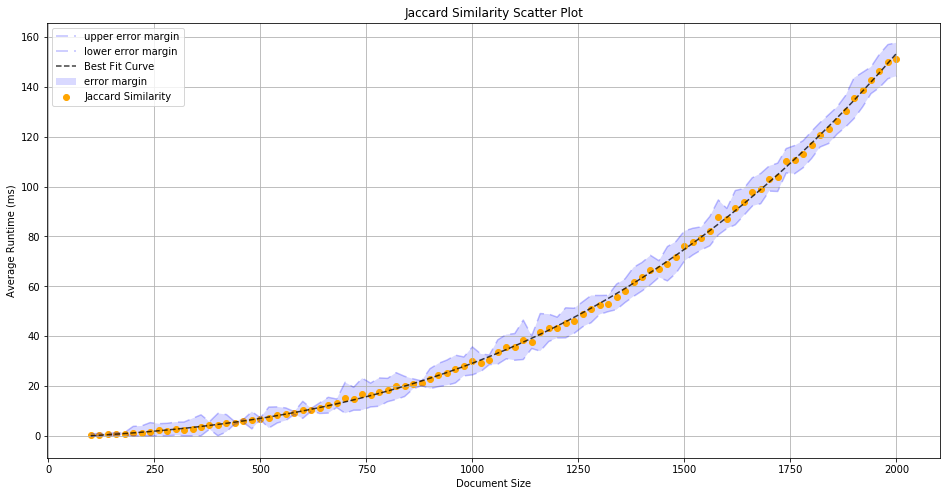

Approximate Equation for line of best fit is: 1.24e-08*x^3 +1.00e-05*x^2 +7.60e-03*x -8.67e-01
Precise coefficient values: 1.2389161271816237e-08 | 1.000940914465656e-05 | 0.00759504792199876 | -0.8674097775351474


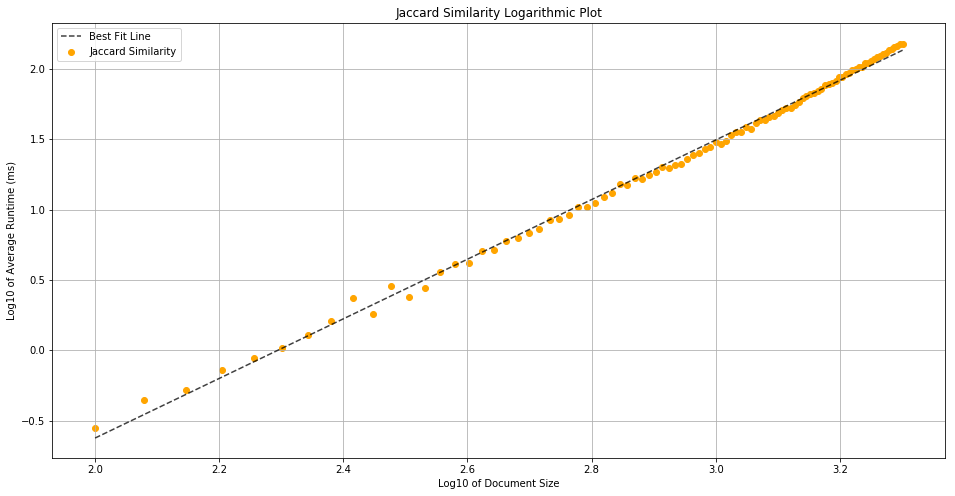

Approximate Equation for line of best fit is: 2.12*x -4.86
Precise coefficient values: 2.119005069251962 | -4.862463523046976


In [9]:
(fig, ax, c) = PlotLinear (xn, yn, funcname='Jaccard Similarity')
(fig, ax, c) = PlotLog (xn, yn, funcname='Jaccard Similarity')

### Results

Our data on the scatter plot clearly demonstrates a quadratic relationship between document size and time complexity.

On our log-log graph, the equation for the line of best fit is $y=2.12x-4.86$. This means our implementation has an asymptotic time complexity of approximately $O(N^{2.12})$, and an implementation constant of $10^{-4.86}$. 

While this is not far from the theoretical value of $O(N^2)$, we suspect that due to having imperfect implementation and experimental control, our empirical data did not match perfectly with the theoretical estimate. With large enough data, we can expect the empirical result to approach the theoretical estimate.

---

# 2. Cosine Similarity (Dense)

In this section, we investigate cosine similarity with dense representation, 
and compare the performance of using our own defined dot product function, and Numpy's function.

Dense representation in this case, refers to representing a document as vectors, 
where each element denotes the number of occurrences of each word in a document. 
With this algorithm, we can treat each document as some non-descript vector, 
and calculate their cosine similarities to find how similar two documents are.

---

### Theoretical Time Complexity

The equation for the cosine similarity measure is given as:

$$ cos(\theta) = \frac{A^T \cdot B}{\sqrt{(A^T \cdot A) \times (B^T \cdot B)}} $$

For $D$ documents with $N$ words, 
**in worst case it is converted to 2 vectors of length $V = DN$ in dense representation.** *(zero overlaps between documents)*

The time complexity of this algorithm is dependent on the *vector length*, and can be given as:

$$ O(3(V + (V - 1)) + 3) $$

Where $ V + (V-1) $ is the time complexity of calculating the dot product of two vectors.  
Again, $+3$ is the constant for the 3 mathematical operations required in the cosine similarity equation, *(square root, multiplication, division)*.

This can be written in terms of document length $N$ and collection size $D$:

$$ O(3(DN + (DN - 1)) + 3) $$

Assuming two documents in collection, this can be written as:

$$ O(3(2N + (2N - 1)) + 3) = O(12N) $$

Where the asymptotic time complexity is:

$$ O(N) $$

---

### Empirical Time Complexity

We define two functions for cosine similarity measure, one using our dot product method, another using Numpy's method:

In [10]:
# Dot Product - Vector
def DotVect (A, B):
    dp = 0;
    for a,b in zip(A,B):
        dp += a * b
    return dp

# Cosine Similarity - Vector
def CosineVect (A, B):
    return DotVect(A,B) / np.sqrt(DotVect(A,A)*DotVect(B,B))

# Cosine Similarity - Vector Numpy
def CosineVectNP (A, B):
    return np.dot(A,B) / np.sqrt(np.dot(A,A)*np.dot(B,B))

### Data Collection

In [11]:
start = 1000
stop = 10000
step = 100
xc = np.arange(start, stop+1, step=step)
yc = np.zeros((xc.size, 2)) # Y[DATA_MYFUNC(i), DATA_NUMPY(i)]
sampleSize = 20

print (f'Testing {xc.size} cases, in range [{xc[0]}, {xc[-1]}]')

for i, size in enumerate(xc):
    collection = GetCollection(2, size, 'vect')
    A = collection[0]
    B = collection[1]
    
    yc[i, 0] = TimeDocument (CosineVect, A, B)[0]
    yc[i, 1] = TimeDocument (CosineVectNP, A, B)[0]
    
    print (f'\ncase {i:3} | document size {size:4} | avg time {yc[i,:]} ms', end='')

Testing 91 cases, in range [1000, 10000]

case   0 | document size 1000 | avg time [1.09891891 0.        ] ms
case   1 | document size 1100 | avg time [1.19698048 0.        ] ms
case   2 | document size 1200 | avg time [1.29919052 0.        ] ms
case   3 | document size 1300 | avg time [1.40144825 0.        ] ms
case   4 | document size 1400 | avg time [1.4993906 0.       ] ms
case   5 | document size 1500 | avg time [1.39629841 0.        ] ms
case   6 | document size 1600 | avg time [1.59907341 0.        ] ms
case   7 | document size 1700 | avg time [0.99725723 0.        ] ms
case   8 | document size 1800 | avg time [1.7988205  0.09734631] ms
case   9 | document size 1900 | avg time [1.79920197 0.        ] ms
case  10 | document size 2000 | avg time [3.1017065 0.       ] ms
case  11 | document size 2100 | avg time [1.89845562 0.        ] ms
case  12 | document size 2200 | avg time [1.99623108 0.        ] ms
case  13 | document size 2300 | avg time [2.09870338 0.        ] ms
case  14 |

### Data Analysis

Approximate Equation for line of best fit is: +8.06e-04*x +4.92e-01
Precise coefficient values: 0.0008064280195702489 | 0.49234422685842366
Approximate Equation for line of best fit is: +6.11e-05*x -1.89e-01
Precise coefficient values: 6.112467238317917e-05 | -0.18899209333426778


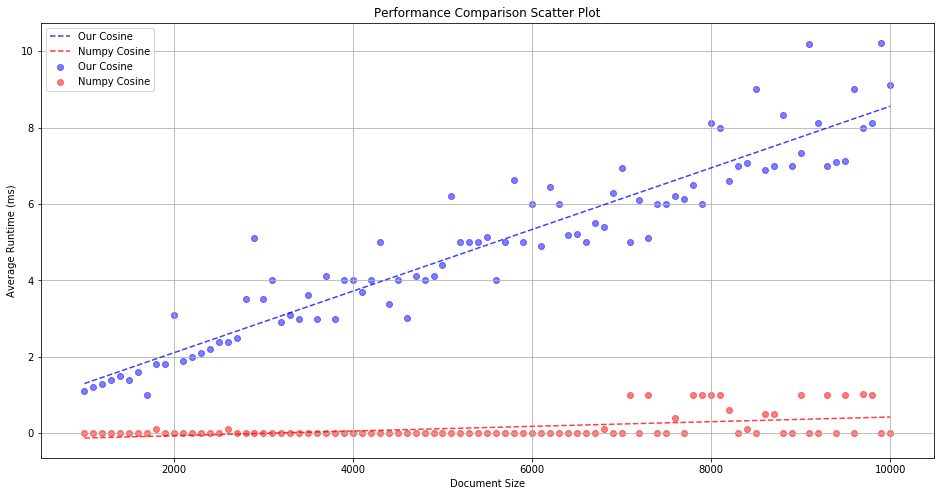

In [12]:
datalabel = ['Our Cosine', 'Numpy Cosine']
colorlist = ['blue', 'red']

(fig, ax, c) = PlotLinearCompare (xc, yc, datalabel, colorlist, typeflag='linear')

### Results

Our scatter plot clearly demonstrates a linear relationship between vector length and time complexity for our implementation.

We can see that our function has a linear time complexity, with a time complexity of approximately $O(8.06\times10^{-4}N)$, and an implementation constant of approximately $0.492$.

However, we note that the results for Numpy's function is anomalous.  
While it is clear that Numpy's dot product implementation is much faster, 
our testing implementation on Jupyter Notebook failed to record the time correctly. 
This results in many of the records being registered as zeros. 
In other environments, such as Google Colab, this problem may not be present.

We believe the reason Numpy's function is much faster is because it is running an optimized, compiled, code.

---

# 3. Cosine Similarity (Sparse)

Sparse representation in this case, refers to storing a document in a Python dictionary.
In this section, we create a function to run cosine similarity of Python dictionaries.

---

### Theoretical Time Complexity

For sparse representation, the worst-case time complexity of the dot product operation is now $O(N_A \times N_B)$; as the algorithm must compare all elements in both documents, $N_A$ and $N_B$.

As such, the time complexity of the cosine similarity measure is now:

$$ O(N_A \times N_B + N_A^2 + N_B^2 + 3) $$

Where each document can have different element counts, $N_A$ and $N_B$.  
Again, $+3$ is the constant for the 3 mathematical operations required in the cosine similarity equation, *(square root, multiplication, division)*.

Assuming both documents have equal elements, this can be simplified to:

$$ O(3N^2 + 3) $$

Where the asymptotic time complexity is:

$$ O(N^2) $$

---

### Empirical Time Complexity

*Once again, we will implement a naive algorithm to investigate the worst-case time complexity.* 

In [13]:
# Dot Product - Dictionary
def DotDict (A, B):
    dp = 0;
    for featA in A:
        for featB in B:
            if featA == featB:
                dp += A.get(featA) * B.get(featB)
    return dp

# Cosine Similarity - Dictionary
def CosineDict (A, B):
    return DotDict(A,B) / np.sqrt(DotDict(A,A)*DotDict(B,B))

### Data Collection

In [14]:
start = 100
stop = 2000
step = 20
xn = np.arange(start, stop+1, step=step)
yn = np.zeros((xn.size, 4))
sampleSize = 25

print (f'Testing {xn.size} cases, in range [{xn[0]}, {xn[-1]}]')

for i, size in enumerate(xn):
    A = GetDocument(size)
    B = GetDocument(size)
    yn[i] = TimeDocument (CosineDict, A, B, sampleSize)
    print (f'\ncase {i:3} | document size {size:4} | avg time {yn[i][0]:3.2f} ms', end='')

Testing 96 cases, in range [100, 2000]

case   0 | document size  100 | avg time 0.92 ms
case   1 | document size  120 | avg time 1.24 ms
case   2 | document size  140 | avg time 1.68 ms
case   3 | document size  160 | avg time 2.08 ms
case   4 | document size  180 | avg time 2.40 ms
case   5 | document size  200 | avg time 3.80 ms
case   6 | document size  220 | avg time 4.00 ms
case   7 | document size  240 | avg time 4.80 ms
case   8 | document size  260 | avg time 5.91 ms
case   9 | document size  280 | avg time 6.45 ms
case  10 | document size  300 | avg time 7.50 ms
case  11 | document size  320 | avg time 8.11 ms
case  12 | document size  340 | avg time 9.79 ms
case  13 | document size  360 | avg time 10.96 ms
case  14 | document size  380 | avg time 12.90 ms
case  15 | document size  400 | avg time 13.94 ms
case  16 | document size  420 | avg time 15.11 ms
case  17 | document size  440 | avg time 16.32 ms
case  18 | document size  460 | avg time 18.17 ms
case  19 | document siz

### Data Analysis

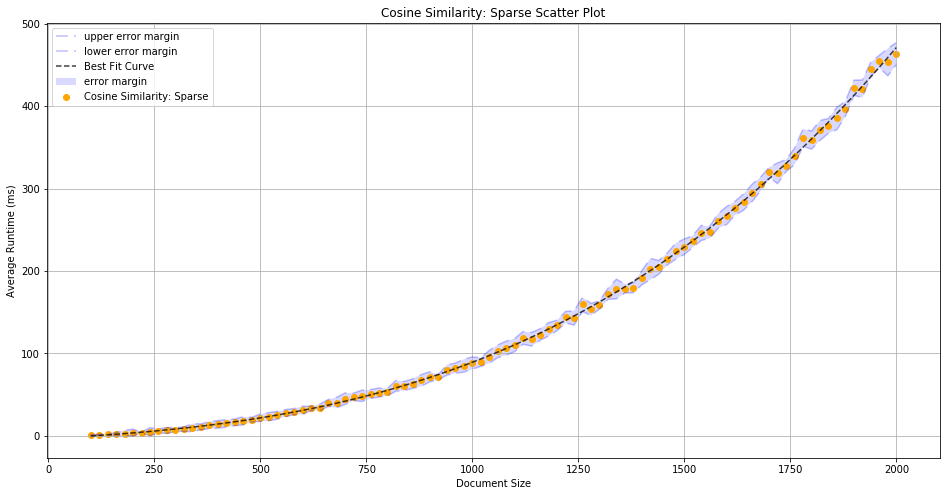

Approximate Equation for line of best fit is: 3.99e-08*x^3 +2.49e-05*x^2 +2.78e-02*x -3.36e+00
Precise coefficient values: 3.992945020982255e-08 | 2.4857050872118285e-05 | 0.02781264170743163 | -3.3621475032365025


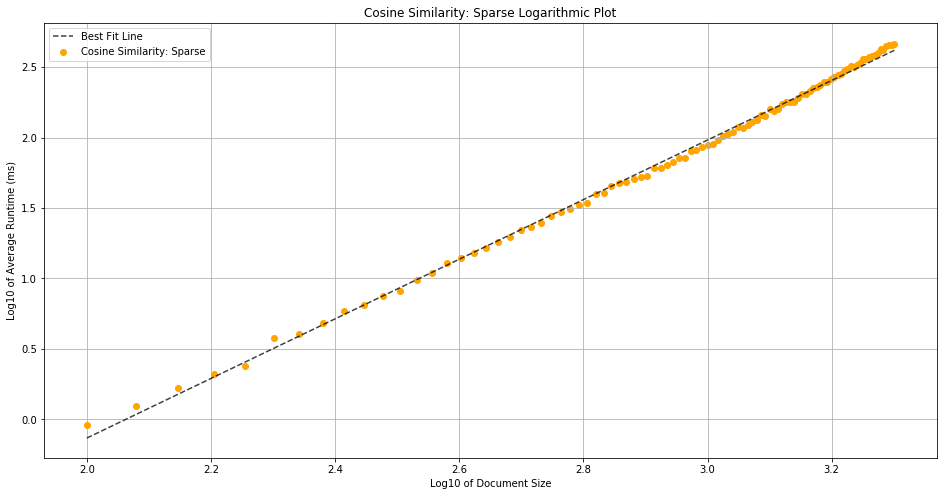

Approximate Equation for line of best fit is: 2.11*x -4.36
Precise coefficient values: 2.1147182575036205 | -4.3620688148092635


In [15]:
(fig, ax, c) = PlotLinear (xn, yn, funcname='Cosine Similarity: Sparse')
(fig, ax, c) = PlotLog (xn, yn, funcname='Cosine Similarity: Sparse')

### Results

Our data on the scatter plot clearly demonstrates a quadratic relationship between document size and time complexity.

On our log-log graph, the equation for the line of best fit is $y=2.11x-4.36$. This means our implementation has an asymptotic time complexity of approximately $O(N^{2.11})$, and an implementation constant of $10^{-4.36}$. 

Again, the discrepancy from the theoretical value of $O(N^2)$ is likely due to imperfect experimental controls.
With large enough sample sizes, we can expect the empirical result to approach the theoretical estimate.

### Comparison to Previous Implementations

Based on the results so far, cosine similarity (dense) is the fastest algorithm, with a linear time complexity.  
However, the tradeoff is it is more computationally expensive to create and store a dense representation
than for a sparse representation.
This is because the total unique word count must be known to create the matrix, 
and we are storing many redundant zeros in our data as many words would never occur within a document.

Additionally, this result is incomplete, as we assume a collection of 2 documents. 
As the collection size grows, the number of redundant data will dramatically increase.

Our results also confirm that Jaccard is faster than cosine (sparse).
This have been shown in our theoretical estimation. 
While both algorithms have an equal asymptotic complexity of $O(N^2)$, 
cosine (sparse) has a much higher constant than Jaccard.

---

# 4. All-pair Document Similarity

In this section, we will investigate the effects of using different similarity measure on all-pair document similarity.

---

### Theoretical Time Complexity

When given a collection of $P$ documents and collection of $Q$ documents,
all-pair similarity of these two collections requires $P \times Q$ comparisons.  
Assuming equal number of documents $N$, we need $PQ = N^2$ comparison operations.

The time complexity of each comparison operation is then based on the algorithm used.  
Assuming all documents have equal number of elements $n$:

#### Jaccard

Given the time complexity: $O(n^2 + 2n + 3)$

The total time complexity of all-pair comparison is: $O(N^2 \times (n^2 + 2n + 3))$

However, the asymptotic time complexity, as a function of $N$, is: $O(N^2)$

#### Cosine Similarity (Sparse)

Given the time complexity: $O(3n^2 + 3)$

The total time complexity of all-pair comparison is: $O(N^2 \times (3n^2 + 3))$

However, the asymptotic time complexity, as a function of $N$, is: $O(N^2)$

Asymptotically, the similarity measure being used would not matter. 
However, in practical implementations Jaccard similarity would be faster due to the smaller complexity constant.

---

### Empirical Time Complexity


In [16]:
"""
Function to calculate all-pair similarity between to document collections
Returns average similarity of all-pairs
"""
def AllPair (fx, collectionA, collectionB):
    result = 0
    n = len(collectionA) * len(collectionB)
    for documentA in collectionA:
        for documentB in collectionB:
            result += fx(documentA, documentB)
    return result / n

### Data Collection

We will compare Jaccard and cosine similarity measure on **varying document count**, but **constant document size**.

In [29]:
functionList = [Jaccard, CosineDict]
DSize = 100
start = 10
stop = 50
step = 1
CSizeList = np.arange(start,stop+1,step=step)
sampleSize = 10

xc = CSizeList
yc = np.zeros((CSizeList.size, len(functionList)))

print (f'Testing {xc.size} cases, in range [{xc[0]}, {xc[-1]}]')

for i, CSize in enumerate(CSizeList):
    for f, function in enumerate(functionList):
        colA = GetCollection(CSize,DSize,'dict')
        colB = GetCollection(CSize,DSize,'dict')
        yc[i,f] = TimeCollection (AllPair, function, colA, colB, sampleSize)[0]
    print(f'\ncase {i:3} | collection size {CSize:4} | Jac:{yc[i][0]:3.2f} ms | Cos:{yc[i][1]:3.2f} ms', end='')

Testing 41 cases, in range [10, 50]

case   0 | collection size   10 | Jac:29.48 ms | Cos:90.95 ms
case   1 | collection size   11 | Jac:36.28 ms | Cos:109.93 ms
case   2 | collection size   12 | Jac:41.18 ms | Cos:128.03 ms
case   3 | collection size   13 | Jac:48.97 ms | Cos:146.12 ms
case   4 | collection size   14 | Jac:55.07 ms | Cos:169.60 ms
case   5 | collection size   15 | Jac:63.26 ms | Cos:194.39 ms
case   6 | collection size   16 | Jac:71.66 ms | Cos:222.47 ms
case   7 | collection size   17 | Jac:81.05 ms | Cos:249.66 ms
case   8 | collection size   18 | Jac:90.75 ms | Cos:280.74 ms
case   9 | collection size   19 | Jac:102.34 ms | Cos:317.42 ms
case  10 | collection size   20 | Jac:113.53 ms | Cos:347.50 ms
case  11 | collection size   21 | Jac:125.63 ms | Cos:387.58 ms
case  12 | collection size   22 | Jac:138.42 ms | Cos:420.86 ms
case  13 | collection size   23 | Jac:148.51 ms | Cos:457.14 ms
case  14 | collection size   24 | Jac:161.61 ms | Cos:498.42 ms
case  15 | co

### Data Analysis

Visualizing the results, we should see Jaccard outperforming cosine similarity in terms of speed.

Approximate Equation for line of best fit is: +1.39e-03*x^3 +1.75e-01*x^2 +2.39e+00*x -1.53e+01
Precise coefficient values: 0.00139082745251725 | 0.17549551175546657 | 2.3903253604501855 | -15.315954860501172
Approximate Equation for line of best fit is: +1.34e-03*x^3 +7.70e-01*x^2 +1.94e+00*x -9.60e+00
Precise coefficient values: 0.0013426356658570928 | 0.7701894844798511 | 1.9408002063534906 | -9.601255181269586


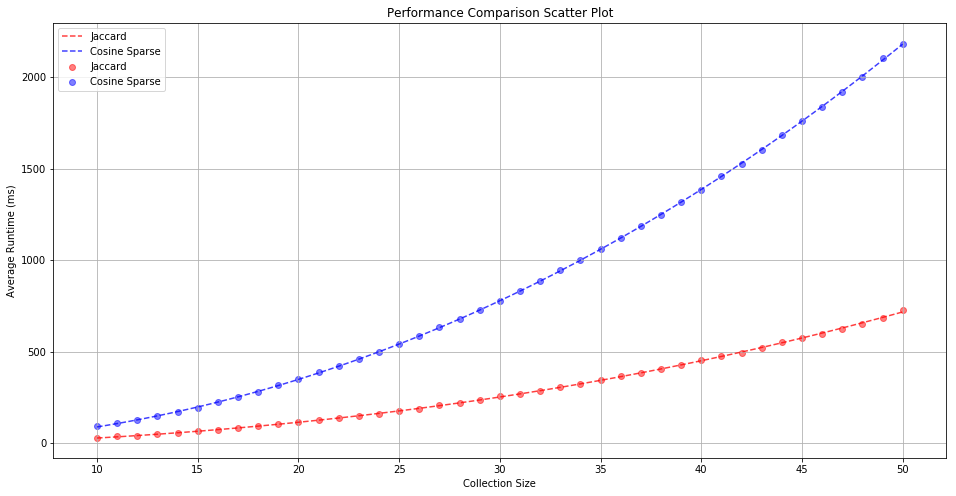

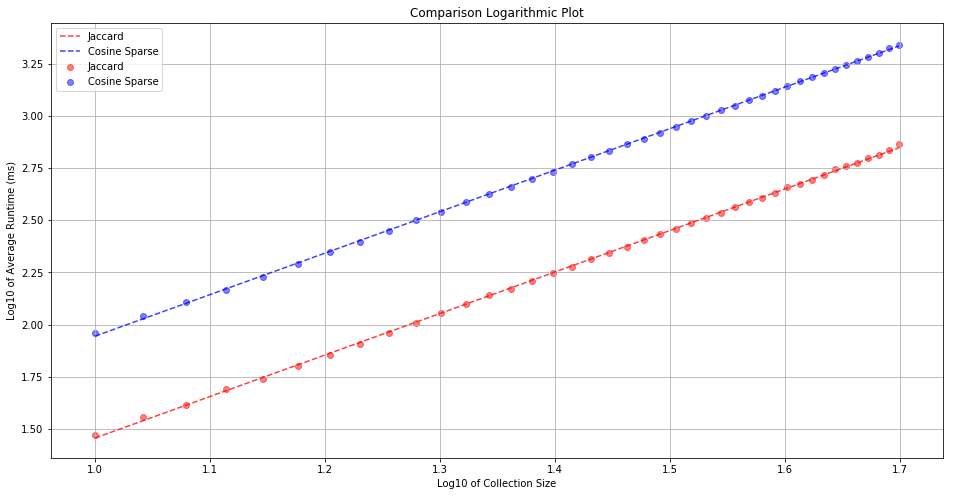

Equations for 2 best fit lines:
	 Jaccard 	= 1.988*x -0.531
	 Cosine Sparse 	= 1.987*x -0.043


In [30]:
datalabel = ['Jaccard', 'Cosine Sparse']
colorlist = ['red', 'blue']

(fig, ax, c) = PlotLinearCompare (xc, yc, datalabel, colorlist, xlabel='Collection Size')
(fig, ax, c) = PlotLogCompare (xc, yc, datalabel, colorlist, xlabel='Log10 of Collection Size')

### Results

As expected, all-pair similarity with Jaccard is faster than with cosine similarity.  
Jaccard similarity has a time complexity of approximately $O(N^{1.988})$ with a constant of $10^{-0.531}$, while using cosine similarity has $O(N^{1.987})$ with a larger constant of $10^{-0.043}$.

However, while the trendline suggests cosine similarity will become faster,
we believe the margin is too close to call, and Jaccard should become slightly faster with more data.

Based on this result, computing all-pairs similarity for 200k documents with 100 words would take:

$$ \mbox{Jaccard: } 1.988\log_{10}{(200,000)} - 0.531 \approx 1.02\times10^{10} ms \approx \mbox{117.7 days}$$

$$ \mbox{Cosine: } 1.987\log_{10}{(200,000)} - 0.043 \approx 3.09\times10^{10} ms \approx \mbox{357.79 days}$$

---

# 5. Map-Reduce Implementation

In this section, we will implement the map-reduce computing paradigm, 
and investigate the effects of different number of map / reduce processes.

---


In [22]:
import mapreduce as MR

""" ========================== Code in attached file ========================== """

"""
indexList = MapperIndex (taggedDocument)
(str, (str,int)) = function ((tuple(str,dict)))

Maps one document, returns list of inverted index of format: [(word, (document_name, word_count))]
"""
# MapperIndex (taggedDocument)

"""
reducedIndex = ReducerIndex (indexList)
(str, int) = function ([(str, int)])

Combines repetitive index tuples (i.e. summing up word count).
Sum repetitions: [(D1,1), (D1,1), (D2,1)] -> [(D1,2), (D2,1)]
Returns list of word count tuples.
"""
# ReducerIndex (indexList)

"""
pairMap = MapperSim (reducedIndex)
[((str,str),int)] = function ([(str,int)]) 

Multiplies dot product for each word occurence.
Sets tag as document pair.

Example IO:
[('A0', 1), ('B1', 2), ('C2', 3)] --> [(('A0','B1'),2), (('A0','B1'),3), (('B1','C2'),6)]
"""
# MapperSim (inList)

"""
value = ReducerSimCos (inTriplet)
float = function (tuple(list[int],list[int],list[int]), str)

Reduces 3 dot product into either cosine similarity.

inTriplet format:
    (AA, AB, BB)
    ([1,1,1],[],[2,3,4,5])
"""
# ReducerSimCos (inTriplet)

"""
value = ReducerSimJac (inTriplet)
float = function (tuple(list[int],list[int],list[int]), str)

Reduces 3 dot product into Jaccard similarity.

inTriplet format:
    (AA, AB, BB)
    ([1,1,1],[],[2,3,4,5])
"""
# ReducerSimJac (inTriplet)

"""
Serial processing version of Map Reduce.
Kept for debugging & Testing.
"""
# MapReduce_Serial (collection, docPair, mapPool, reducePool, measure='cosine')

""" ========================== Code in attached file ========================== """

from multiprocessing import Pool
import itertools
from collections import defaultdict

"""
taggedCollection = TagCollection (bagOfWordCollection, prefix)
list[tuple(str,dict)] = function(list[dict] , str)

Tags all documents in a collection with some given prefix and sequential numbering:
[bag_of_words{}] -> [(document_name, bag_of_words{})]
"""
def TagCollection (collection, prefix):
    counter = 0
    tagCol = []
    for document in collection:
        tag = prefix + str(counter)
        tagCol.append((tag, document))
        counter += 1
    return tagCol

"""
docPair = GenDocList (tagSet)
list[tuple(str,str)] = function (list[tuple(str,dict)])

Generates a list of possible document pairing, for all-pair document similarity measure.
"""
def GenDocList (tagSet):
    docList = []
    for (doc,_) in tagSet:
        docList.append(doc)
    docPair = []
    for i in range(0, len(docList)):
        for j in range(i, len(docList)):
            docPair.append((docList[i], docList[j]))
    return docPair

"""
simList = MapReduce (collection, docPair, measure)
dict{tuple,float} = function (list[tuple(str,dict)], list[tuple(str,str)], str)

Parallel Map-Reduce function for inverse indexing & all-pair document similarity measure.
Can use either cosine or Jaccard similarity measure.
Mapper / Reducer Functions are hard-coded.

measure value:
    'cosine' : Returns Cosine Similarity
    'jaccard' : Returns Jaccard Similarity
"""

def MapReduce (collection, docPair, mapPool, reducePool, measure='cosine'):
    
    """ --- Inverted Indexing --- """
    
    # Map -- Creates list of list
    indexList = mapPool.map(MR.MapperIndex, collection)
    
    # Shuffle -- Unstacks list of list
    collector = defaultdict(list)
    for subList in indexList:
        for (key, value) in subList:
            collector[key].append(value)
    
    # Reduce -- Creates list of list
    sumList = reducePool.map(MR.ReducerIndex, collector.values())
    
    # Unstacks list of list
    reducedIndex = defaultdict(list)
    for key, subList in zip(collector.keys(), sumList):
        reducedIndex[key].extend(subList)
    
    """ --- Pairwise Similarity --- """
    
    # Map -- Creates list of list
    # Dot Product of Words -- Don't care about the word itself anymore
    output = mapPool.map(MR.MapperSim, reducedIndex.values())
    
    # Unstacsk list of list
    mapResult = defaultdict(list)
    for subList in output:
        for (docpair,score) in subList:
                mapResult[docpair].append(score)
    
    # Shuffle -- put results into pairwise group
    collector = defaultdict(list)
    for (keyA, keyB) in docPair:
        AA = mapResult.get((keyA,keyA),[])
        AB = mapResult.get((keyA,keyB),[])
        BB = mapResult.get((keyB,keyB),[])
        collector[(keyA,keyB)] = (AA, AB, BB)
    
    # Reduce -- Creates list of list
    if measure == 'cosine':
        simList = reducePool.map(MR.ReducerSimCos, collector.values())
    elif measure == 'jaccard':
        simList = reducePool.map(MR.ReducerSimJac, collector.values())
    
    # Pair document-pair with their similarity score
    reducedSim = {}
    for key, score in zip(collector.keys(), simList):
        reducedSim[key] = score
    
    return reducedSim

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

"""
Timing Map Reduce Paradigm
"""
def TimeParallel (MapReduce, tagSet, docPair, mapPool, reducePool, measure, SampleSize):
    t = np.zeros(SampleSize)
    for i in range(SampleSize):
        st = time.time()
        MapReduce(tagSet, docPair, mapPool, reducePool, measure)
        et = time.time()
        t[i] = et - st
    t *= 1000
    mean = np.mean(t)
    total = np.sum(t)
    
    return (mean, total)

"""
Test Bench for Map Reduce
"""
def MapReduceTestBench (mapPoolList, reducePoolList, measure, CSize, DSize, sampleSize):
    z = np.zeros( (len(mapPoolList)*len(reducePoolList)) )
    c = 0
    for x, mnum in enumerate(mapPoolList):
        for y, rnum in enumerate(reducePoolList):
            print (f'Map: {mnum} Red: {rnum} |', end=' ')
            mapPool = Pool(processes=mnum)
            reducePool = Pool(processes=rnum)

            rawSet = GetCollection(CSize,DSize,'dict')
            tagSet = TagCollection (rawSet, 'D')
            docPair = GenDocList (tagSet)

            (z[c], total) = TimeParallel (MapReduce, tagSet, docPair, mapPool, reducePool, measure, sampleSize)

            mapPool.close()
            reducePool.close()
            print (f'Avg time: {z[c]:.2f} ms | Total time: {total:.2f} ms')
            c += 1
    return z

"""
3D plotter for mapper-reducer processes

Data: x,y,z are all vectors of the same length.
This function handles reshaping them automatically.

xstep and ystep is simply xtick and ytick values.
"""
def LandscapePlot (x, y, z, xstep, ystep, **kwargs):
    fig = kwargs.get( 'fig', plt.figure(figsize=kwargs.get('figsize',(12,12))) )
    ax = kwargs.get( 'ax', fig.add_subplot(kwargs.get('subplot',111) , projection='3d') )
    
    X = np.reshape(x, (xstep.size,ystep.size))
    Y = np.reshape(y, (xstep.size,ystep.size))
    Z = np.reshape(z, (xstep.size,ystep.size))
    
    # Plot Surface
    cmap = kwargs.get('cmap',cm.jet)
    surf = ax.plot_surface(X, Y, Z, 
                           rstride=1, cstride=1, cmap=cmap, zorder=1, alpha=kwargs.get('alpha',1),
                           linewidth=1, antialiased=True, shade=True)
    cticks = np.arange(np.floor(np.min(z)), np.ceil(np.max(z)), kwargs.get('ctickstep',10) )
    cbar = fig.colorbar(surf, shrink=kwargs.get('colorbar_shrink',1), aspect=12, ticks=cticks, extend='both')
    cbar.set_label('Avg time (ms)\n', rotation=270, fontsize=12, labelpad=20)
    
    ax.set_xlabel( kwargs.get('xlabel','Map Processes (X)'), fontsize=kwargs.get('xlabel_fontsize',10) )
    ax.set_ylabel( kwargs.get('ylabel','Reduce Processes (Y)'), fontsize=kwargs.get('ylabel_fontsize',10) )
    ax.set_zlabel( kwargs.get('zlabel','Avg Time (ms)'), fontsize=kwargs.get('zlabel_fontsize',10) )
    ax.set_title( kwargs.get('title','Map Reduce'), fontsize=kwargs.get('title_fontsize',10))
    ax.view_init( kwargs.get('view_v',60), 180+kwargs.get('view_h',60))

    plt.xticks(np.arange(1,xstep.size+1))
    plt.yticks(np.arange(1,ystep.size+1))
    
    # Find Minimum
    xmin = x[np.argmin(z)]
    ymin = y[np.argmin(z)]
    zmin = z[np.argmin(z)]
    minLabel = "Minimum: ({0:d}, {1:d}, {2:.2f})".format(xmin, ymin, zmin)
    minPoint = ax.scatter(xmin,ymin,zmin, label=minLabel, color='green', s=50, zorder=10)
    
    # Find Maximum
    xmax = x[np.argmax(z)]
    ymax = y[np.argmax(z)]
    zmax = z[np.argmax(z)]
    maxLabel = "Maximum: ({0:d}, {1:d}, {2:.2f})".format(xmax, ymax, zmax)
    maxPoint = ax.scatter(xmax,ymax,zmax, label=maxLabel, color='fuchsia', s=50, zorder=10)
    
    ax.legend(loc='lower left')
    
    return (fig, ax)

### Methodology

We will focus on varying processes count, while keeping the collection and document size constant.  
We will only vary the collection and document size once to get a rough sense of the time complexity.

We have kept the functions `Pool()` and `Pool.close()`, and document preprocessing outside of the timing loop. 
This is to isolate the time complexity of the Map-Reduce function itself, and to minimize function overheads. 
As in the real world, parallel processing nodes would be on standby, rather than having to reinitialize for every task.

---

### Data Collection

We will run repeated trials and take the average time as the result for each setting.

In [23]:
# X-Axis
mapPoolList = np.arange(1,10)
xs = np.repeat(mapPoolList, mapPoolList.size)

# Y-Axis
reducePoolList = np.arange(1,10)
ys = np.tile(reducePoolList, mapPoolList.size)

# Test Parameter
CSize = 50
DSize = 100
sampleSize = 10

# Cosine Similarity
measure = 'cosine'
print (f'Running Cosine Similarity:\n')
zcos = MapReduceTestBench (mapPoolList, reducePoolList, measure, CSize, DSize, sampleSize)

# Jaccard Similarity
measure = 'jaccard'
print (f'\nRunning Jaccard Similarity:\n')
zjac = MapReduceTestBench (mapPoolList, reducePoolList, measure, CSize, DSize, sampleSize)

CSize = 100
DSize = 500

# Cosine Similarity
measure = 'cosine'
print (f'Running Cosine Similarity:\n')
zcosLarge = MapReduceTestBench (mapPoolList, reducePoolList, measure, CSize, DSize, sampleSize)

# Jaccard Similarity
measure = 'jaccard'
print (f'\nRunning Jaccard Similarity:\n')
zjacLarge = MapReduceTestBench (mapPoolList, reducePoolList, measure, CSize, DSize, sampleSize)

print('\nDone!')

Running Cosine Similarity:

Map: 1 Red: 1 | Avg time: 173.88 ms | Total time: 1738.83 ms
Map: 1 Red: 2 | Avg time: 188.75 ms | Total time: 1887.55 ms
Map: 1 Red: 3 | Avg time: 197.78 ms | Total time: 1977.80 ms
Map: 1 Red: 4 | Avg time: 214.25 ms | Total time: 2142.54 ms
Map: 1 Red: 5 | Avg time: 200.69 ms | Total time: 2006.88 ms
Map: 1 Red: 6 | Avg time: 207.08 ms | Total time: 2070.80 ms
Map: 1 Red: 7 | Avg time: 238.45 ms | Total time: 2384.49 ms
Map: 1 Red: 8 | Avg time: 221.13 ms | Total time: 2211.33 ms
Map: 1 Red: 9 | Avg time: 230.80 ms | Total time: 2308.00 ms
Map: 2 Red: 1 | Avg time: 197.28 ms | Total time: 1972.77 ms
Map: 2 Red: 2 | Avg time: 167.95 ms | Total time: 1679.53 ms
Map: 2 Red: 3 | Avg time: 174.19 ms | Total time: 1741.94 ms
Map: 2 Red: 4 | Avg time: 173.98 ms | Total time: 1739.76 ms
Map: 2 Red: 5 | Avg time: 190.92 ms | Total time: 1909.21 ms
Map: 2 Red: 6 | Avg time: 207.75 ms | Total time: 2077.49 ms
Map: 2 Red: 7 | Avg time: 215.67 ms | Total time: 2156.67

Map: 6 Red: 9 | Avg time: 258.61 ms | Total time: 2586.06 ms
Map: 7 Red: 1 | Avg time: 229.24 ms | Total time: 2292.43 ms
Map: 7 Red: 2 | Avg time: 200.37 ms | Total time: 2003.69 ms
Map: 7 Red: 3 | Avg time: 201.49 ms | Total time: 2014.93 ms
Map: 7 Red: 4 | Avg time: 239.55 ms | Total time: 2395.55 ms
Map: 7 Red: 5 | Avg time: 236.29 ms | Total time: 2362.90 ms
Map: 7 Red: 6 | Avg time: 227.29 ms | Total time: 2272.95 ms
Map: 7 Red: 7 | Avg time: 251.15 ms | Total time: 2511.52 ms
Map: 7 Red: 8 | Avg time: 255.69 ms | Total time: 2556.93 ms
Map: 7 Red: 9 | Avg time: 260.31 ms | Total time: 2603.09 ms
Map: 8 Red: 1 | Avg time: 207.96 ms | Total time: 2079.60 ms
Map: 8 Red: 2 | Avg time: 225.62 ms | Total time: 2256.22 ms
Map: 8 Red: 3 | Avg time: 210.39 ms | Total time: 2103.91 ms
Map: 8 Red: 4 | Avg time: 222.44 ms | Total time: 2224.36 ms
Map: 8 Red: 5 | Avg time: 232.30 ms | Total time: 2323.03 ms
Map: 8 Red: 6 | Avg time: 267.09 ms | Total time: 2670.95 ms
Map: 8 Red: 7 | Avg time

Map: 3 Red: 7 | Avg time: 849.34 ms | Total time: 8493.39 ms
Map: 3 Red: 8 | Avg time: 893.99 ms | Total time: 8939.93 ms
Map: 3 Red: 9 | Avg time: 903.16 ms | Total time: 9031.63 ms
Map: 4 Red: 1 | Avg time: 800.93 ms | Total time: 8009.27 ms
Map: 4 Red: 2 | Avg time: 866.06 ms | Total time: 8660.56 ms
Map: 4 Red: 3 | Avg time: 748.51 ms | Total time: 7485.11 ms
Map: 4 Red: 4 | Avg time: 800.98 ms | Total time: 8009.78 ms
Map: 4 Red: 5 | Avg time: 776.95 ms | Total time: 7769.49 ms
Map: 4 Red: 6 | Avg time: 811.12 ms | Total time: 8111.22 ms
Map: 4 Red: 7 | Avg time: 787.36 ms | Total time: 7873.61 ms
Map: 4 Red: 8 | Avg time: 835.58 ms | Total time: 8355.79 ms
Map: 4 Red: 9 | Avg time: 794.42 ms | Total time: 7944.18 ms
Map: 5 Red: 1 | Avg time: 806.38 ms | Total time: 8063.79 ms
Map: 5 Red: 2 | Avg time: 720.34 ms | Total time: 7203.45 ms
Map: 5 Red: 3 | Avg time: 766.78 ms | Total time: 7667.84 ms
Map: 5 Red: 4 | Avg time: 709.90 ms | Total time: 7099.00 ms
Map: 5 Red: 5 | Avg time

### Data Analysis

As we have two independent variables to test, we will plot the results on a 3D XYZ plane.

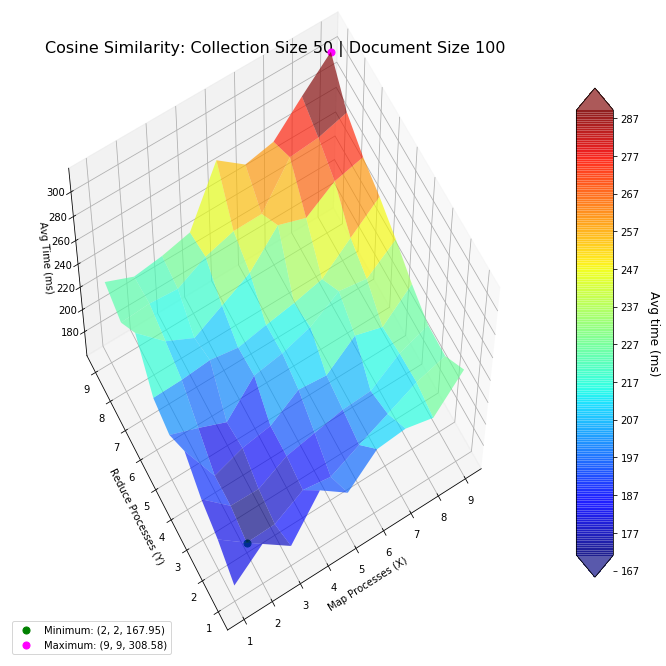

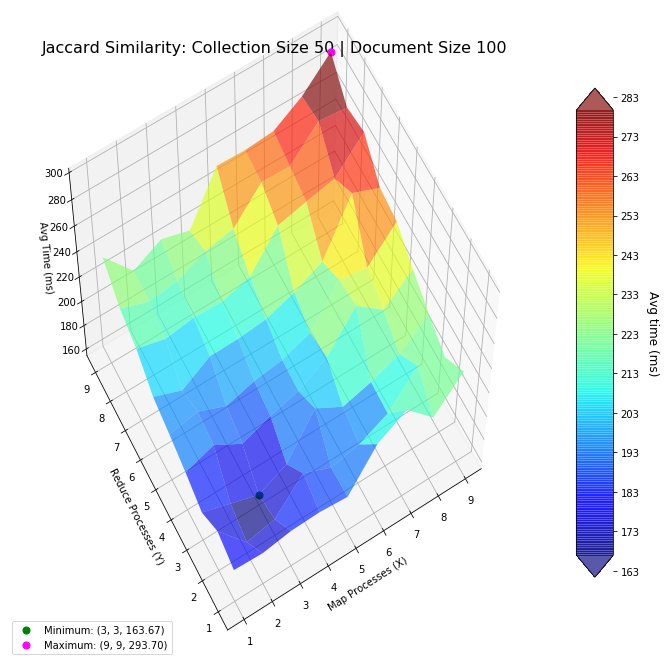

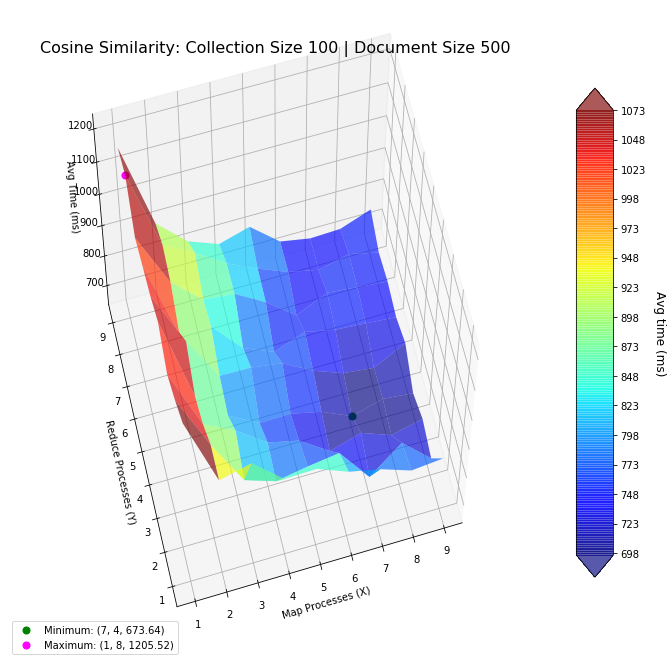

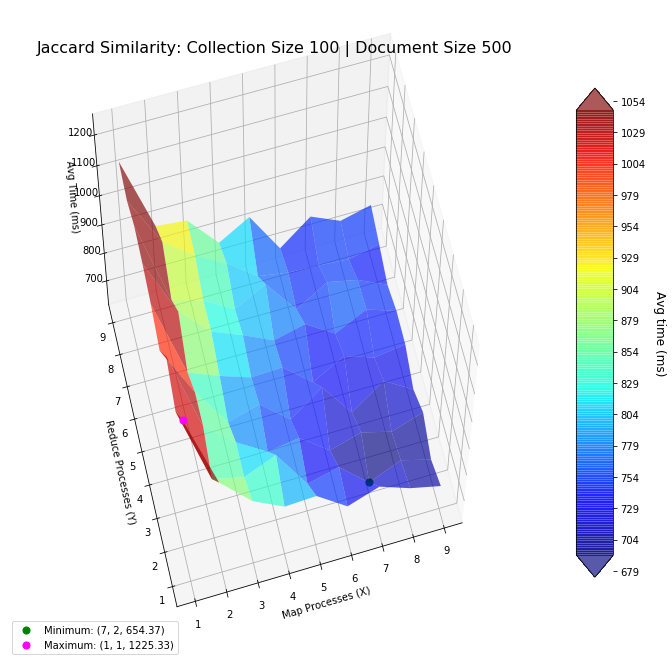

In [28]:
(fig, ax) = LandscapePlot (xs, ys, zcos, mapPoolList, reducePoolList,
                           colorbar_shrink=0.75, alpha=0.65,
                           title='Cosine Similarity: Collection Size 50 | Document Size 100', title_fontsize=16)
(fig, ax) = LandscapePlot (xs, ys, zjac, mapPoolList, reducePoolList,
                           colorbar_shrink=0.75, alpha=0.65,
                           title='Jaccard Similarity: Collection Size 50 | Document Size 100', title_fontsize=16)

(fig, ax) = LandscapePlot (xs, ys, zcosLarge, mapPoolList, reducePoolList,
                           colorbar_shrink=0.75, ctickstep=25, view_h=75, view_v=60, alpha=0.65,
                           title='Cosine Similarity: Collection Size 100 | Document Size 500', title_fontsize=16)
(fig, ax) = LandscapePlot (xs, ys, zjacLarge, mapPoolList, reducePoolList,
                           colorbar_shrink=0.75, ctickstep=25, view_h=75, view_v=60, alpha=0.65,
                           title='Jaccard Similarity: Collection Size 100 | Document Size 500', title_fontsize=16)

### Results

We can see that in our implementation, parallel processing is much faster than serial processing.   
With collection size 50, document size 100: serial processing requires over 2000ms (cosine) or 500ms (Jaccard) on average (see section 4 results), while the parallel implementation, at worst, takes less than 300ms on average. 

We can observe that too many processes can result in a sub-optimal performance. We can reason that with more processes, communication and function overhead adds up, while giving a diminishing return in added parallel performance (not enough work to do). 

We can also see that the optimal combination varies with problem size. 
The larger the collection and document size, more processes becomes faster. 

A general trend we can see, is more map processes results in better performance, while reduce seems to matter less. We believe this is because mapping process is more computationally intensive than reducing processes, so there is more to be gained from adding mapper process. 

Based on our limited results, the optimal settings seem to be reducers less than or equal to mappers, where the best number of mappers varies with problem size. 

We can see that both similarity measures are close in performance, but Jaccard is slightly faster. We expect that as the problem size grows, the difference will become more apparent. 

However, we note that our documents are completely randomized, and have very little similarity to each other. 
This may have affected the results, as less similarity means more work was reduced by our algorithm.
Real world text may see less increase in performance.

Additionally, it is still unclear precisely how varying the problem size affects the landscape. While we believe it is likely the effects are similar (increasing either one increases the number of words), it is still possible that one variable may be more efficient for reducer functions than mapper functions, or vice versa. An in-depth investigation of this problem’s topology may be warranted. 

---


# Conclusion

In this report, we have investigated the theoretical and empirical time complexity of document similarity functions. 

We have seen that with sparse representations, Jaccard is a faster algorithm; while the dense representation with cosine similarity is the fastest method but requires more work to format data and is less memory efficient. 

Finally, we have investigated the Map-Reduce paradigm, and conclude that it is much more efficient than serial processing methods. 